In [195]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import multiprocessing
from PIL import Image
import cv2
import requests
import pandas as pd

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
import torchvision

# Data Visualization
from PIL import Image
import matplotlib.pyplot as plt
import random
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Visualization of Paintings
from IPython.display import Image

# ! pip install kornia
# !pip install grad-cam

# kornia imports
import kornia
import kornia.augmentation as K
import kornia.geometry.transform as T

# Activation map
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image

from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.metrics.cam_mult_image import DropInConfidence, IncreaseInConfidence
from pytorch_grad_cam.sobel_cam import sobel_cam
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirstAverage
from pytorch_grad_cam.metrics.road import ROADLeastRelevantFirstAverage, ROADMostRelevantFirstAverage
from pytorch_grad_cam.metrics.road import ROADCombined
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM

seed = 211
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [196]:
# Data augmentation and normalization for training
# Just normalization for validation and testing
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Data augmentation using Kornia
transform_train = K.AugmentationSequential(
    K.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.333)),
    K.RandomRotation(degrees=(-10, 10)),
    K.RandomHorizontalFlip(),
    K.RandomAffine(degrees=(0, 0), scale=(1.0, 1.1), shear=(0, 0)),  # Zoom
    K.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    same_on_batch=False
)
transform_val_test = K.AugmentationSequential(
    K.CenterCrop(size=(224, 224)),
    K.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    same_on_batch=False
)

In [197]:
def create_dataloaders(batch_size=32, data_dir=None):
    image_datasets = {x: ImageFolder(os.path.join(data_dir, x), transform=preprocess) for x in
                      ['train', 'validation', 'test']}
    train_loader = DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(image_datasets['validation'], batch_size=batch_size)
    test_loader = DataLoader(image_datasets['test'], batch_size=batch_size)
    dataloaders = {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader
    }
    class_names = image_datasets['train'].classes
    return image_datasets, dataloaders, class_names

In [198]:
batch_size = 32
data_dir = './drive/MyDrive/deep_learn/project/dataset'

# Create the dataloaders
image_datasets, dataloaders, class_names = create_dataloaders(batch_size=batch_size, data_dir=data_dir)

In [199]:
def set_parameter_requires_grad(model, feature_extracting=False):
    # approach 1
    if feature_extracting:
        # frozen model
        model.requires_grad_(False)
    else:
        # fine-tuning
        model.requires_grad_(True)

In [200]:
# for LoRA/DoRA
class LowRankLayer(nn.Module):
    def __init__(self, linear, rank, alpha, use_dora=True):
        super().__init__()
        # rank: controls the inner dimension of the matrices A and B; controls the number of additional parameters introduced by LoRA,
        # a key factor in determining the balance between model adaptability and parameter efficiency.
        # alpha: a scaling hyper-parameter applied to the output of the low-rank adaptation,
        # controls the extent to which the adapted layer's output is allowed to influence the original output of the layer being adapted.

        self.use_dora = use_dora
        self.rank = rank  # low-rank
        self.alpha = alpha  # scaling hyper-parameter
        self.linear = linear
        self.in_dim = linear.in_features
        self.out_dim = linear.out_features

        # weights
        std_dev = 1 / torch.sqrt(torch.tensor(self.rank).float())
        self.A = nn.Parameter(torch.randn(self.in_dim, self.rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(self.rank, self.out_dim))

        if self.use_dora:
            self.m = nn.Parameter(
                self.linear.weight.norm(p=2, dim=0, keepdim=True))
        else:
            self.m = None

    def forward(self, x):
        lora = self.A @ self.B  # combine LoRA matrices
        if self.use_dora:
            numerator = self.linear.weight + self.alpha * lora.T
            denominator = numerator.norm(p=2, dim=0, keepdim=True)
            directional_component = numerator / denominator
            new_weight = self.m * directional_component
            return F.linear(x, new_weight, self.linear.bias)
        else:
            # combine LoRA with orig. weights
            combined_weight = self.linear.weight + self.alpha * lora.T
            return F.linear(x, combined_weight, self.linear.bias)


In [201]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True, DoRA=False, LoRA=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    weights = 'DEFAULT' if use_pretrained else None

    if model_name == "cnn_mobile_net":
        model_ft = models.mobilenet_v3_small(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        rank, alpha = 4, 8
        if DoRA:
            model_ft.classifier[0] = LowRankLayer(model_ft.classifier[0], rank, alpha, use_dora=True)
        if LoRA:
            model_ft.classifier[0] = LowRankLayer(model_ft.classifier[0], rank, alpha, use_dora=False)
        num_ftrs = model_ft.classifier[3].in_features
        model_ft.classifier[3] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "cnn_resnet50":
        model_ft = models.resnet50(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vit_base_16":       # supervised visual transformer model - 86.6M params
        model_ft = models.vit_b_16(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.heads[0].in_features
        model_ft.heads[0] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vit_dino_v2":           # self-supervised visual transformer model - 91.5M params
        model_ft = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_lc')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.linear_head.in_features
        model_ft.linear_head = nn.Linear(num_ftrs, num_classes)

    else:
        raise NotImplementedError

    return model_ft

In [202]:
opt_models = ["cnn_mobile_net", "cnn_resnet50", "vit_base_16", "vit_dino_v2"]
CNN_model_name = opt_models[1]
ViT_model_name = opt_models[2]
num_classes = len(class_names)
num_epochs = 20
# Flag for feature extracting. When False, we fine-tune the whole model,
# when True we only update the reshaped layer params
feature_extract = True
LoRA = False
DoRA = False
train = True

In [203]:
# training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    model = model.to(device)
    since = time.time()

    train_loss, train_acc, val_loss, val_acc = [], [], [], []
    history = [train_loss, train_acc, val_loss, val_acc]


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Kornia augmentation
                if phase == 'train':
                    inputs = transform_train(inputs)
                else:
                    inputs = transform_val_test(inputs)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_loss.append(epoch_loss), train_acc.append(epoch_acc.cpu())

                # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss.append(epoch_loss), val_acc.append(epoch_acc.cpu())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [204]:
# plot the best model
def plot_test_results(hist):

    epochs = len(hist[0])

    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    axes[0].plot(range(1, epochs + 1), hist[0], label='Training')
    axes[0].plot(range(1, epochs + 1), hist[2], label='Validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_title('Loss')
    axes[0].legend(loc='best')

    axes[1].plot(range(1, epochs + 1), hist[1], label='Training')
    axes[1].plot(range(1, epochs + 1), hist[3], label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_title('Accuracy')
    axes[1].legend(loc='best')

    plt.tight_layout()
    plt.show()

In [205]:
best_models = [CNN_model_name, ViT_model_name]
models_save_dir = './drive/MyDrive/deep_learn/project/models'
models_save_names = []
histories_save_dir = './drive/MyDrive/deep_learn/project/histories'

if not os.path.exists(models_save_dir):
    os.makedirs(models_save_dir)

if not os.path.exists(histories_save_dir):
    os.makedirs(histories_save_dir)

history_titles = ["train_loss", "train_acc", "val_loss", "val_acc"]

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/19
----------
train Loss: 0.6952 Acc: 0.5131
val Loss: 0.6792 Acc: 0.6471

Epoch 1/19
----------
train Loss: 0.6716 Acc: 0.5929
val Loss: 0.6556 Acc: 0.6667

Epoch 2/19
----------
train Loss: 0.6582 Acc: 0.6155
val Loss: 0.6349 Acc: 0.7157

Epoch 3/19
----------
train Loss: 0.6351 Acc: 0.6536
val Loss: 0.6240 Acc: 0.7255

Epoch 4/19
----------
train Loss: 0.6290 Acc: 0.6702
val Loss: 0.6127 Acc: 0.7255

Epoch 5/19
----------
train Loss: 0.6192 Acc: 0.6833
val Loss: 0.5994 Acc: 0.7451

Epoch 6/19
----------
train Loss: 0.6084 Acc: 0.6940
val Loss: 0.5936 Acc: 0.7451

Epoch 7/19
----------
train Loss: 0.5963 Acc: 0.7083
val Loss: 0.5830 Acc: 0.7353

Epoch 8/19
----------
train Loss: 0.6027 Acc: 0.7131
val Loss: 0.5725 Acc: 0.7353

Epoch 9/19
----------
train Loss: 0.5904 Acc: 0.7012
val Loss: 0.5680 Acc: 0.7745

Epoch 10/19
----------
train Loss: 0.5878 Acc: 0.7036
val Loss: 0.5632 Acc: 0.7843

Epoch 11/19
----------
train Loss: 0.5778 Acc: 

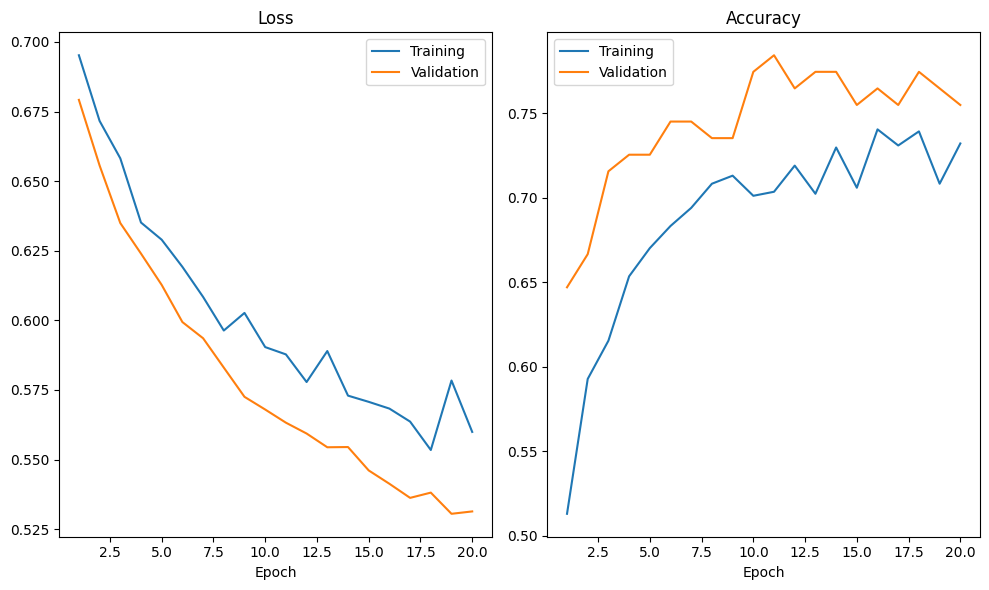

Params to learn:
	 heads.head.weight
	 heads.head.bias
Epoch 0/19
----------
train Loss: 0.6339 Acc: 0.6464
val Loss: 0.5274 Acc: 0.7647

Epoch 1/19
----------
train Loss: 0.5322 Acc: 0.7238
val Loss: 0.5013 Acc: 0.8039

Epoch 2/19
----------
train Loss: 0.5110 Acc: 0.7607
val Loss: 0.5016 Acc: 0.8137

Epoch 3/19
----------
train Loss: 0.5061 Acc: 0.7667
val Loss: 0.4961 Acc: 0.7843

Epoch 4/19
----------
train Loss: 0.4790 Acc: 0.7929
val Loss: 0.5074 Acc: 0.7549

Epoch 5/19
----------
train Loss: 0.4782 Acc: 0.7786
val Loss: 0.4910 Acc: 0.8235

Epoch 6/19
----------
train Loss: 0.4884 Acc: 0.7821
val Loss: 0.4841 Acc: 0.8137

Epoch 7/19
----------
train Loss: 0.4818 Acc: 0.7738
val Loss: 0.4843 Acc: 0.8333

Epoch 8/19
----------
train Loss: 0.5014 Acc: 0.7643
val Loss: 0.4752 Acc: 0.7843

Epoch 9/19
----------
train Loss: 0.4841 Acc: 0.7750
val Loss: 0.4749 Acc: 0.7843

Epoch 10/19
----------
train Loss: 0.4716 Acc: 0.7845
val Loss: 0.4694 Acc: 0.8333

Epoch 11/19
----------
train Lo

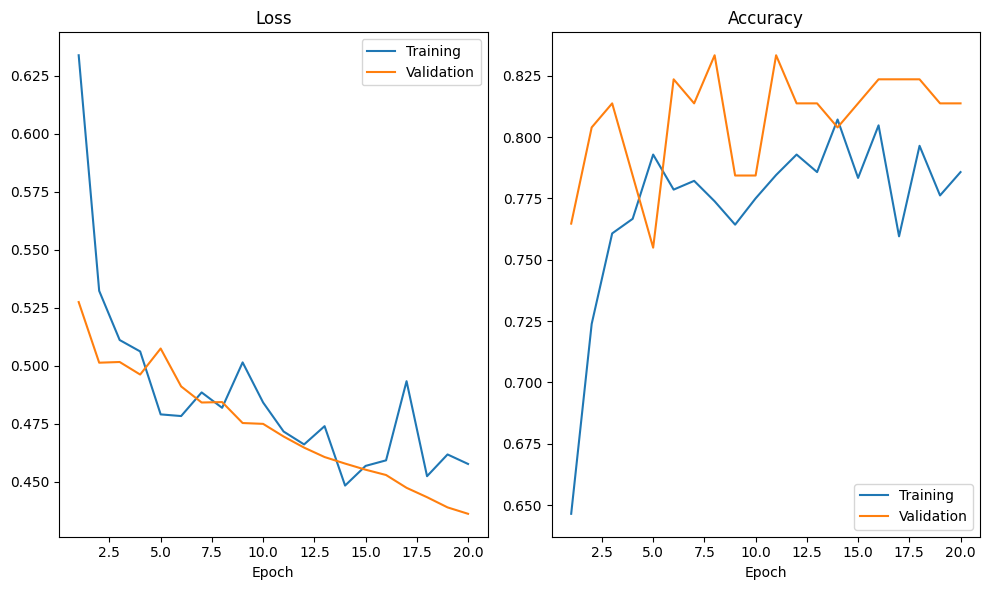

In [206]:
for model in best_models:

    # create save name for the model
    save_name = model + '_bs_' + str(batch_size) + '_ep_' + str(num_epochs)
    save_name = save_name + '_fe' if feature_extract else save_name + '_ft_'
    if model == CNN_model_name:
        save_name = save_name + '_DoRA' if DoRA else save_name + '_LoRA' if LoRA else save_name
    save_name += '.pth'
    models_save_names.append(save_name)


    # Initialize the model for this run
    if model == CNN_model_name:
        model_ft = initialize_model(model, num_classes, feature_extract,
                                                        use_pretrained=True, DoRA=DoRA, LoRA=LoRA)
    else:
        model_ft = initialize_model(model, num_classes, feature_extract,
                                                        use_pretrained=True)

    # Print the model we just instantiated
    # print(model_ft)

    model_ft = model_ft.to(device)

    params_to_update = model_ft.parameters()
    # Observe that all parameters are being optimized
    optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)
    # Setup the loss fn
    criterion = nn.CrossEntropyLoss()

    if train:

        print("Params to learn:")
        if feature_extract:
            params_to_update = []  # override the initial list definition above
            for name, param in model_ft.named_parameters():
                if param.requires_grad == True:
                    params_to_update.append(param)
                    print("\t", name)
        else:
            for name, param in model_ft.named_parameters():
                if param.requires_grad == True:
                    print("\t", name)


        # Train and evaluate
        model_ft, history = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

        # plot loss and accuracy
        plot_test_results(history)

        # save model
        model_save_path = os.path.join(models_save_dir, save_name)
        torch.save(model_ft.state_dict(), model_save_path)

        # save the history in csv file with titles: train_loss, train_acc, val_loss, val_acc
        history_save_name = "history_" + model + "_" + ".csv"
        history_save_path = os.path.join(histories_save_dir, history_save_name)
        history_dict = {title: history[i] for i, title in enumerate(history_titles)}
        history_dict_df = pd.DataFrame(history_dict)
        history_dict_df.to_csv(history_save_path, index=False)


In [207]:
# load models
CNN_weights_path = os.path.join(models_save_dir, models_save_names[0])
# CNN_weights_path = os.path.join(models_save_dir, 'model_MN_v3_s_bz_32_ep_20_fe.pth')
CNN_best = initialize_model(best_models[0], num_classes, feature_extract, use_pretrained=True, DoRA=DoRA, LoRA=LoRA)
CNN_best.load_state_dict(torch.load(CNN_weights_path, map_location=device))

ViT_weights_path = os.path.join(models_save_dir, models_save_names[1])
ViT_best = initialize_model(best_models[1], num_classes, feature_extract, use_pretrained=True)
ViT_best.load_state_dict(torch.load(ViT_weights_path, map_location=device))

<All keys matched successfully>

In [208]:
# testing function
def test_model(model, test_loader, criterion, optimizer, num_epochs=25):
    model = model.to(device)

    model.eval()
    running_loss = 0.0
    running_corrects = 0

    all_preds = []
    all_probs = []

    # Iterate over data
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Kornia augmentation
        inputs = transform_val_test(inputs)

        # forward
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            # classes probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            # class prediction
            _, preds = torch.max(outputs, 1)
            # add to history
            all_preds.append(preds.detach().cpu().numpy())
            all_probs.append(probs.detach().cpu().numpy())

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)

    print('Test loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))


    return epoch_loss, epoch_acc, all_preds, all_probs

##### PREDCITIONS ON TEST DATA ######

In [209]:
test_ds = image_datasets['test']
class_names_bin = test_ds.classes
label_to_str = {index: value for index, value in enumerate(class_names_bin)}
test_file_list = test_ds.imgs
# True classes
y_true = np.array(test_ds.targets)

In [210]:
# Make predictions for each of the two models (Evaluate on the test set)
CNN_test_loss, CNN_test_acc, CNN_preds, CNN_probs = test_model(CNN_best, dataloaders['test'], criterion, optimizer_ft, num_epochs=num_epochs)
ViT_test_loss, ViT_test_acc, ViT_preds, ViT_probs = test_model(ViT_best, dataloaders['test'], criterion, optimizer_ft, num_epochs=num_epochs)

Test loss: 0.4804 Acc: 0.8670
Test loss: 0.3203 Acc: 0.8989


In [211]:
y_pred_cnn = np.concatenate(CNN_preds)
y_pred_vit = np.concatenate(ViT_preds)

y_prob_cnn = np.concatenate(CNN_probs)
y_prob_vit = np.concatenate(ViT_probs)


print('CNN model, test set accuracy: {:5.2f}%'.format(100 * CNN_test_acc))
print('ViT model, test set accuracy: {:5.2f}%'.format(100 * ViT_test_acc))

CNN model, test set accuracy: 86.70%
ViT model, test set accuracy: 89.89%


In [212]:
# Define function to plot Confusion matrix depending on model
def plot_CM(model_name, data=test_ds):

    if model_name == "CNN":
        pred_labels = y_pred_cnn
    elif model_name == "ViT":
        pred_labels = y_pred_vit
    else:
        print("Provide either CNN or ViT as model_name.")

    acc_score = np.mean(pred_labels == y_true)
    # get the confusion plot
    cm = sklearn.metrics.confusion_matrix(y_true, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names_bin)
    return (disp)

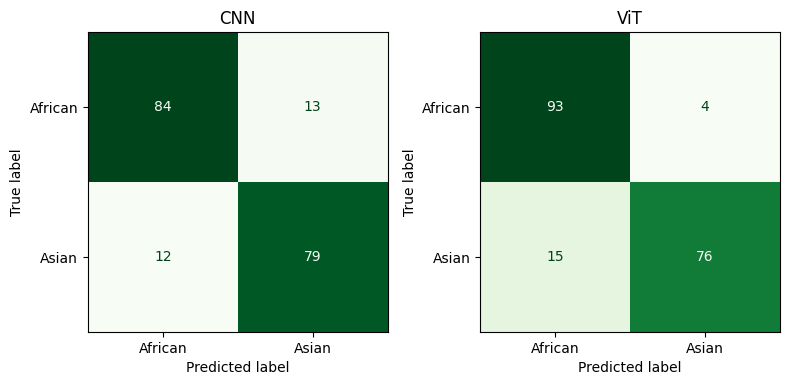

In [213]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
plot_CM('CNN').plot(ax=ax[0], cmap="Greens", colorbar=False)
ax[0].set_title('CNN')
plot_CM('ViT').plot(ax=ax[1], cmap="Greens", colorbar=False)
ax[1].set_title('ViT')
plt.tight_layout()
plt.show()

In [214]:
#### PLOTTING FUNCTION
# Define a function that plots 1 test set image and their corresponding prediction
def plotting_img_by_idx(test_file_list, idx_list, n_img=1, resize=False):

    idx_list = np.array(list(idx_list))
    # get n_img random elements from the list without replacement
    idx_list = idx_list[random.sample(range(0, len(idx_list)), n_img)]

    for i in range(len(idx_list)):
        idx = idx_list[i]
        if resize:      # optional - resize all images to shape (244,224, 3)
            img = Image.open(test_file_list[idx][0])
            img = img.resize((224, 224))
            img = np.array(img)
        else:
            img = plt.imread(test_file_list[idx][0])
        true_label = label_to_str[y_true[idx]]

        # cnn
        pred_label_cnn = label_to_str[y_pred_cnn[idx]]
        prob_cnn = np.max(y_prob_cnn[idx])

        # vit
        pred_label_vit = label_to_str[y_pred_vit[idx]]
        prob_vit = np.max(y_prob_vit[idx])


        # set title colors depending on prediction success
        if pred_label_cnn == true_label:
            color_cnn = 'green'
        else:
            color_cnn = 'red'

        # set title colors depending on prediction success
        if pred_label_vit == true_label:
            color_vit = 'green'
        else:
            color_vit = 'red'

        # format title labels
        cnn_text = "CNN: {} {:2.0f}% ({})".format(pred_label_cnn, 100 * prob_cnn, pred_label_cnn == true_label)
        vit_text = "ViT: {} {:2.0f}% ({})".format(pred_label_vit, 100 * prob_vit, pred_label_vit == true_label)

        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(cnn_text, color=color_cnn, x=0.5, y=1)
        plt.suptitle(vit_text, color=color_vit, x=0.5, y=0.99)
        plt.axis("off")
        plt.show()

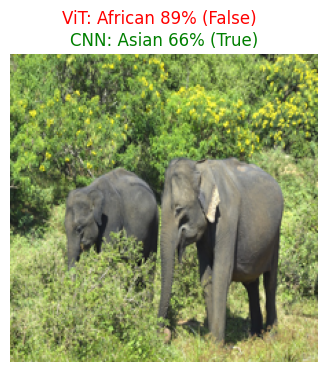

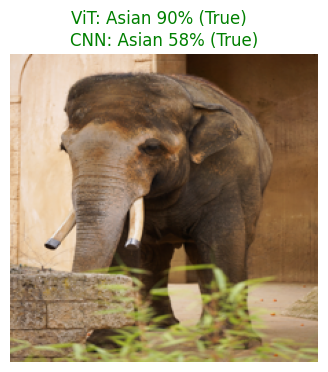

In [216]:
from PIL import Image

n_images = 4
idx_list = random.sample(range(len(y_true)), n_images)
plotting_img_by_idx(test_file_list, idx_list, n_img=2, resize=True)

In [217]:
false_cnn_idx = np.flatnonzero((y_true != y_pred_cnn))
false_vit_idx = np.flatnonzero((y_true != y_pred_vit))

# set intersection give us the commonly shared image id's of the two lists
false_both_idx = list(set(false_cnn_idx) & set(false_vit_idx))

# get idx list for cnn misses but vit hits
cnn_false_vit_hit = set(false_cnn_idx).difference(set(false_both_idx))

# Printing results
print(f'Total test set cases: {len(y_true)}')
print(
    "Incorrect classifications in {}: {}\nIncorrect classifications in {}: {}\nIncorrectly classified by both Models: {}".format(
        "CNN",
        len(false_cnn_idx),
        "ViT",
        len(false_vit_idx),
        len(false_both_idx)))
print(
    "That means:\n{:4.1f}% (n={}) of the {} misclassifications were correctly classified by the {} and\n{:4.1f}% (n={}) of the {} misclassifications were correctly classified by the {}.".format(
        100 * (1 - (len(false_both_idx) / len(false_cnn_idx))),
        len(cnn_false_vit_hit),
        "CNN", "ViT",
        100 * (1 - (len(false_both_idx) / len(false_vit_idx))),
        len(false_vit_idx) - len(false_both_idx),
        "ViT", "CNN"))

Total test set cases: 188
Incorrect classifications in CNN: 25
Incorrect classifications in ViT: 19
Incorrectly classified by both Models: 7
That means:
72.0% (n=18) of the CNN misclassifications were correctly classified by the ViT and
63.2% (n=12) of the ViT misclassifications were correctly classified by the CNN.


### CNN activation maps

In [223]:
# image_path = r".\drive\MyDrive\deep_learn\project\dataset\test\African\af_te19.jpg"
image_path = './drive/MyDrive/deep_learn/project/dataset/test/Asian/as_te69.jpg'

true_label = image_path.split("/")[-2]
if true_label == "African":
    true_label_id = 0
else:
    true_label_id = 1

img = np.array(Image.open(image_path))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [226]:
# predict the image class
# model = CNN_best
# model = models.resnet50(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)

model = models.mobilenet_v3_small(weights='DEFAULT')
num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load('./drive/MyDrive/deep_learn/project/models/cnn_mobile_net_bs_32_ep_20_fe.pth'))
model.eval()

output = model(input_tensor)
output = F.softmax(output, dim=1)
predicted_label_id = np.argmax(output.cpu().data.numpy())
if predicted_label_id == 0:
    predicted_label = "African"
    confidence = output.cpu().data.numpy()[0][0] * 100
else:
    predicted_label = "Asian"
    confidence = output.cpu().data.numpy()[0][1] * 100
print(
    f"the predicted label is {predicted_label} with confidence {confidence:.2f}% where the true label is {true_label}")

the predicted label is Asian with confidence 74.53% where the true label is Asian


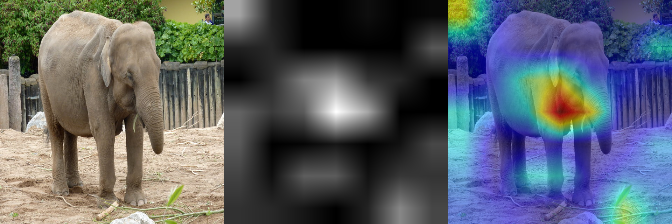

In [227]:
targets = [ClassifierOutputTarget(predicted_label_id)]

# target_layers are all the features and avgpool layers
target_layers = [model.features, model.avgpool]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255 * grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255 * img), cam, cam_image))
Image.fromarray(images)

The confidence increase percent: 18.21964681148529
The visualization of the pertubated image for the metric:


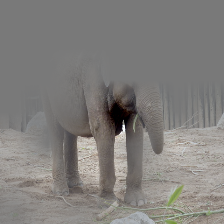

In [162]:
# # Now lets see how to evaluate this explanation:
# # For the metrics we want to measure the change in the confidence, after softmax, that's why
# # we use ClassifierOutputSoftmaxTarget.
# input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# targets = [ClassifierOutputSoftmaxTarget(predicted_label_id)]
# cam_metric = CamMultImageConfidenceChange()
# scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
# score = scores[0]
# visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
# visualization = deprocess_image(visualization)
# print(f"The confidence increase percent: {100*score}")
# print("The visualization of the pertubated image for the metric:")
# Image.fromarray(visualization)

In [163]:
# print("Drop in confidence", DropInConfidence()(input_tensor, grayscale_cams, targets, model))
# print("Increase in confidence", IncreaseInConfidence()(input_tensor, grayscale_cams, targets, model))

Drop in confidence [0.]
Increase in confidence [1.]


The confidence increase percent: 0.008416861295700073
The visualization of the pertubated image for the metric:


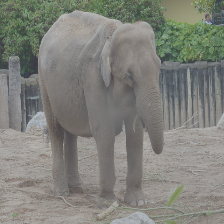

In [164]:
# inverse_cams = 1 - grayscale_cams
# scores, visualizations = CamMultImageConfidenceChange()(input_tensor, inverse_cams, targets, model, return_visualization=True)
# score = scores[0]
# visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
# visualization = deprocess_image(visualization)
# print(f"The confidence increase percent: {score}")
# print("The visualization of the pertubated image for the metric:")
# Image.fromarray(visualization)

The confidence increase: -0.019860297441482544
The visualization of the pertubated image for the metric:


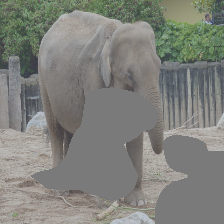

In [165]:
# thresholded_cam = grayscale_cams < np.percentile(grayscale_cams, 75)
# scores, visualizations = CamMultImageConfidenceChange()(input_tensor, thresholded_cam, targets, model, return_visualization=True)
# score = scores[0]
# visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
# visualization = deprocess_image(visualization)
# print(f"The confidence increase: {score}")
# print("The visualization of the pertubated image for the metric:")
# Image.fromarray(visualization)

The confidence increase: 0.08088305592536926
The visualization of the pertubated image for the metric:


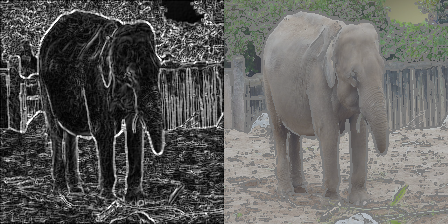

In [166]:
# sobel_cam_grayscale = sobel_cam(np.uint8(img * 255))
# thresholded_cam = sobel_cam_grayscale < np.percentile(sobel_cam_grayscale, 75)

# cam_metric = CamMultImageConfidenceChange()
# scores, visualizations = cam_metric(input_tensor, [thresholded_cam], targets, model, return_visualization=True)
# score = scores[0]
# visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
# visualization = deprocess_image(visualization)
# print(f"The confidence increase: {score}")
# print("The visualization of the pertubated image for the metric:")
# sobel_cam_rgb = cv2.merge([sobel_cam_grayscale, sobel_cam_grayscale, sobel_cam_grayscale])
# Image.fromarray(np.hstack((sobel_cam_rgb, visualization)))

The confidence increase when removing 25% of the image: -0.6263484358787537
The confidence increase when removing 10% of the image: -0.2791288197040558
The visualizations:


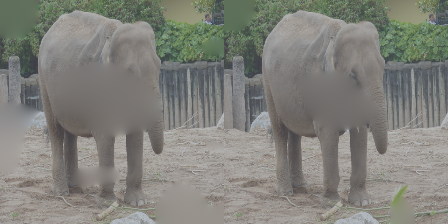

In [228]:
cam_metric = ROADMostRelevantFirst(percentile=75)
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase when removing 25% of the image: {score}")

cam_metric = ROADMostRelevantFirst(percentile=90)
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization_10 = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization_10 = deprocess_image(visualization_10)
print(f"The confidence increase when removing 10% of the image: {score}")
print("The visualizations:")
Image.fromarray(np.hstack((visualization, visualization_10)))

In [168]:
# cam_metric = ROADMostRelevantFirstAverage(percentiles=[20, 40, 60, 80])
# scores = cam_metric(input_tensor, grayscale_cams, targets, model)
# print(f"The average confidence increase with ROAD accross 4 thresholds: {scores[0]}")
# scores = cam_metric(input_tensor, [sobel_cam_grayscale], targets, model)
# print(f"The average confidence increase for Sobel edge detection with ROAD accross 4 thresholds: {scores[0]}")

# cam_metric = ROADMostRelevantFirstAverage(percentiles=[20, 40, 60, 80])
# scores = cam_metric(input_tensor, grayscale_cams * 0, targets, model)
# print(f"Empty CAM, Most relevant first avg confidence increase with ROAD accross 4 thresholds: {scores[0]}")

# cam_metric = ROADLeastRelevantFirstAverage(percentiles=[20, 40, 60, 80])
# scores = cam_metric(input_tensor, grayscale_cams * 0, targets, model)
# print(f"Empty CAM, Least relevant first avg confidence increase with ROAD accross 4 thresholds: {scores[0]}")

# cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
# scores = cam_metric(input_tensor, grayscale_cams * 0, targets, model)
# print(f"Empty CAM, Combined metric avg confidence increase with ROAD accross 4 thresholds (positive is better): {scores[0]}")

The average confidence increase with ROAD accross 4 thresholds: -0.054890140891075134
The average confidence increase for Sobel edge detection with ROAD accross 4 thresholds: 0.10025990009307861


100%|██████████| 18/18 [00:00<00:00, 45.52it/s]


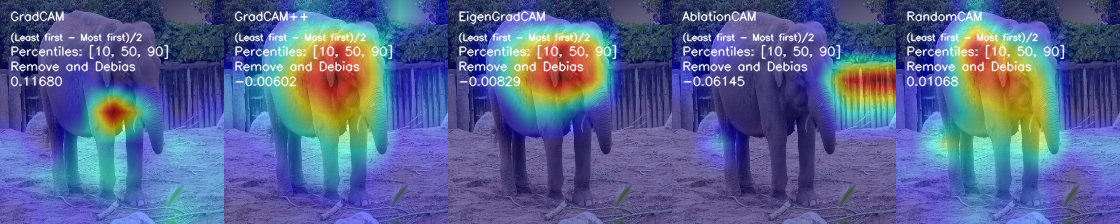

In [169]:
# Showing the metrics on top of the CAM :
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=0):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]

    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor,
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(img, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.features, model.avgpool]

model.cuda()
input_tensor = input_tensor.cuda()
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=predicted_label_id)

100%|██████████| 18/18 [00:00<00:00, 183.79it/s]


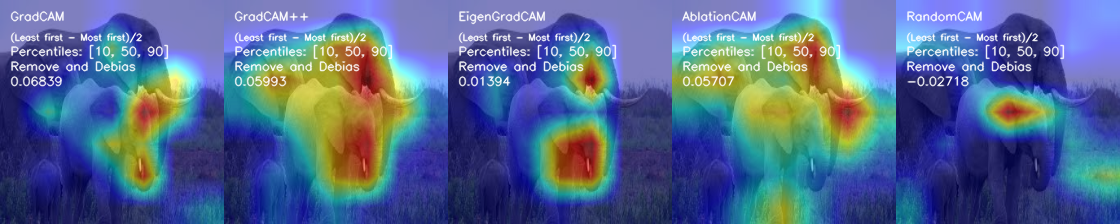

In [86]:
# Let's look how it looks for the other category
benchmark(input_tensor, target_layers, category = 1 - predicted_label_id)